In [2]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import pytz
from tqdm import tqdm
from decimal import Decimal


In [5]:
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe

format_k = lambda x, pos: f'{x/10**3:,.0f}K'
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')
import warnings
# 忽略 pandas 警告
warnings.filterwarnings('ignore')
from matplotlib import font_manager

font_dirs = ['../Fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)



In [17]:
import pandas as pd
def read_large_csv(file_path, chunk_size=1000000):
    accumulated_data = pd.DataFrame()
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    for chunk in chunks:
        accumulated_data = pd.concat([accumulated_data, chunk])
    return accumulated_data

In [16]:
#please change the path of date_validator_reward.csv to your local path
data=read_large_csv('/local/scratch/exported/Ethereum_token_txs_data/rewards/date_validator_reward.csv')
data.shape

(28149005, 6)

In [17]:
data.head(2)

,date,validator_index,Total reward,Proposer reward,Attestation reward,Sync committee reward
0,2022-09-15,1,0.002300,0.0,0.002300,0.0
1,2022-09-15,2,0.002276,0.0,0.002276,0.0


# Index calculation

> To calculate the Shanon entropy,HHI, Gini index and the Nakamoto coefficient of the distribution of the rewards among validators, we have two scripts:

>The first script(suggested): cd to the folder `scripts`, run the script in the terminal `calculate_index1_shanon_entropy.py`,
`calculate_index2_hhi.py`, 
`calculate_index3_gini_index.py` 
`calculate_index4_nakamoto_coefficient.py` 
  

>The second script: run the following cells  until `Gini index plot` cell.

In [32]:
def index(df):
    df['value'] = df['value'].astype(float)
    df['prop'] = df['value']/df['value'].sum() 
    H = -df['prop']*np.log2(df['prop'])
    E = H.sum()
    V = 2**E
    return V

def HHI(df):
    df['value'] = df['value'].astype(float)
    df['prop'] = df['value']/df['value'].sum() 
    SQ = df['prop']**2
    V = SQ.sum()
    return V

def gini(df):
    """
    Compute Gini coefficient of a DataFrame with a 'value' column
    """
    # Check if the DataFrame is empty or the 'value' column does not exist
    if df.empty or 'value' not in df.columns:
        return None 
    # Extract the 'value' column and convert it to a sorted list
    values = sorted(df['value'].tolist())
    # Check if the list is empty
    if len(values) == 0:
        return None
    # Compute the cumulative sum of the values
    cum_values = [0] + list(pd.Series(values).cumsum())
    n = len(values)
    # Calculate Gini coefficient using the formula
    numer = sum([(i+1) * values[i] for i in range(n)])
    denom = n * sum(values)
    if denom == 0:
        return None  # Avoid division by zero
    gini = (2 * numer) / denom - (n + 1) / n
    return gini

def nakamoto(df,validator_number):
    df['value'] = df['value'].astype(float)
    df.sort_values(by=['value'],ascending=False,inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.set_index(keys=df.index.values+1,inplace=True)
    df['prop'] = df['value']/df['value'].sum() 
    df['cumprop'] = df['prop'].cumsum(axis=0)
    try:
        V = df[df['cumprop'] > 0.5].index[0]
        return V/validator_number
    except:
        return 0


In [33]:
from datetime import date
start = date(2022,9,15)
end = date(2022,11,15)

In [34]:
"""
def index_calc(data):

            :param data: dataframe containing transaction value and timestamp of the transaction (block_timestamp)
            :type data: pandas.DataFrame object
            :param start: the start date of calculation 00:00:00 UTC
            :type start: datetime.date object
            :param end: the end date of calculation 23:59:59 UTC
            :type end: datetime.date object
            :param index_type: the metrics used for measuring decentralization, default is our index
            :type index_type: index function

    returns pandas dataframe with decentralization index value and date
"""
from tqdm import tqdm
def index_calc(data, start, end, index_type = index):
    duration= pd.date_range(start=start, end=end)
    days = np.size(duration)
    IndexValues = pd.DataFrame(np.zeros(days), columns=['val'])
    IndexValues['date'] = duration

    for i in tqdm(range(0, days)):
        start_date = start + timedelta(days=i)
        end_date = start_date + timedelta(days=1)
        IndexValues.loc[i,'val'] = index_type(data[(data['Date'].dt.date > start_date) & (data['Date'].dt.date < end_date)].copy())
    return IndexValues
    

In [37]:
data.sort_values(by=['date'],ascending=True,inplace=True)

In [59]:
data.head(5)

,Date,Validator_index,final_total_sum,proposer_total_reward,attestation_total_reward,sync_total_reward
4902107,2022-09-15,107242,2282269,0,2282269,0
4938035,2022-09-15,143174,2311335,0,2311335,0
4938036,2022-09-15,143175,2336083,0,2336083,0
4938037,2022-09-15,143176,2339536,0,2339536,0
4938038,2022-09-15,143177,2285473,0,2285473,0


## shanon entropy of validator's reward

In [139]:
#input transaction data and desired date range
#returns index value 1 if specification range exceeds data 
start = date(2022,9,15)
end = date(2022,11,16)
results = index_calc(data,start,end)

  0%|          | 0/63 [00:00<?, ?it/s]

In [123]:
results

,val,date
0,343355.884109,2022-09-15
1,351274.247678,2022-09-16
2,648974.785487,2022-09-17
3,342529.276095,2022-09-18
4,585185.586917,2022-09-19
...,...,...
57,365539.214555,2022-11-11
58,440961.830361,2022-11-12
59,366709.081461,2022-11-13
60,623858.251846,2022-11-14


In [28]:
results.to_csv('ShannonIndex.csv',index=False)

## HHI of validator's reward

In [29]:
#specify alternate index metric: HHI
#returns index value 0 if specification range exceeds data
start = date(2022,9,15)
end = date(2022,11,15)
results_HHI = index_calc(data,start,end,HHI)
results_HHI.to_csv('HHI_Index.csv',index=False)

100%|██████████| 62/62 [09:04<00:00,  8.78s/it]


In [31]:
results_HHI

,val,date
0,0.000007,2022-09-15
1,0.000006,2022-09-16
2,0.000006,2022-09-17
3,0.000007,2022-09-18
4,0.000007,2022-09-19
...,...,...
57,0.000005,2022-11-11
58,0.000005,2022-11-12
59,0.000006,2022-11-13
60,0.000006,2022-11-14


## GINI index of validator's reward

In [67]:
#specify alternate index metric: gini
#returns index value 0 if specification range exceeds data
start = date(2022,9,15)
end = date(2022,11,15)
results_Gini = index_calc(data,start,end,gini)
results_Gini.to_csv('Gini_Index.csv',index=False)

100%|██████████| 62/62 [09:38<00:00,  9.33s/it]


## Nakamoto coefficient of validator's reward

In [ ]:
start = date(2022,9,15)
end = date(2022,11,15)
results_Nakamoto = index_calc(data,start,end,nakamoto)
results_Nakamoto.to_csv('Nakamoto_Index.csv',index=False)

## index plot

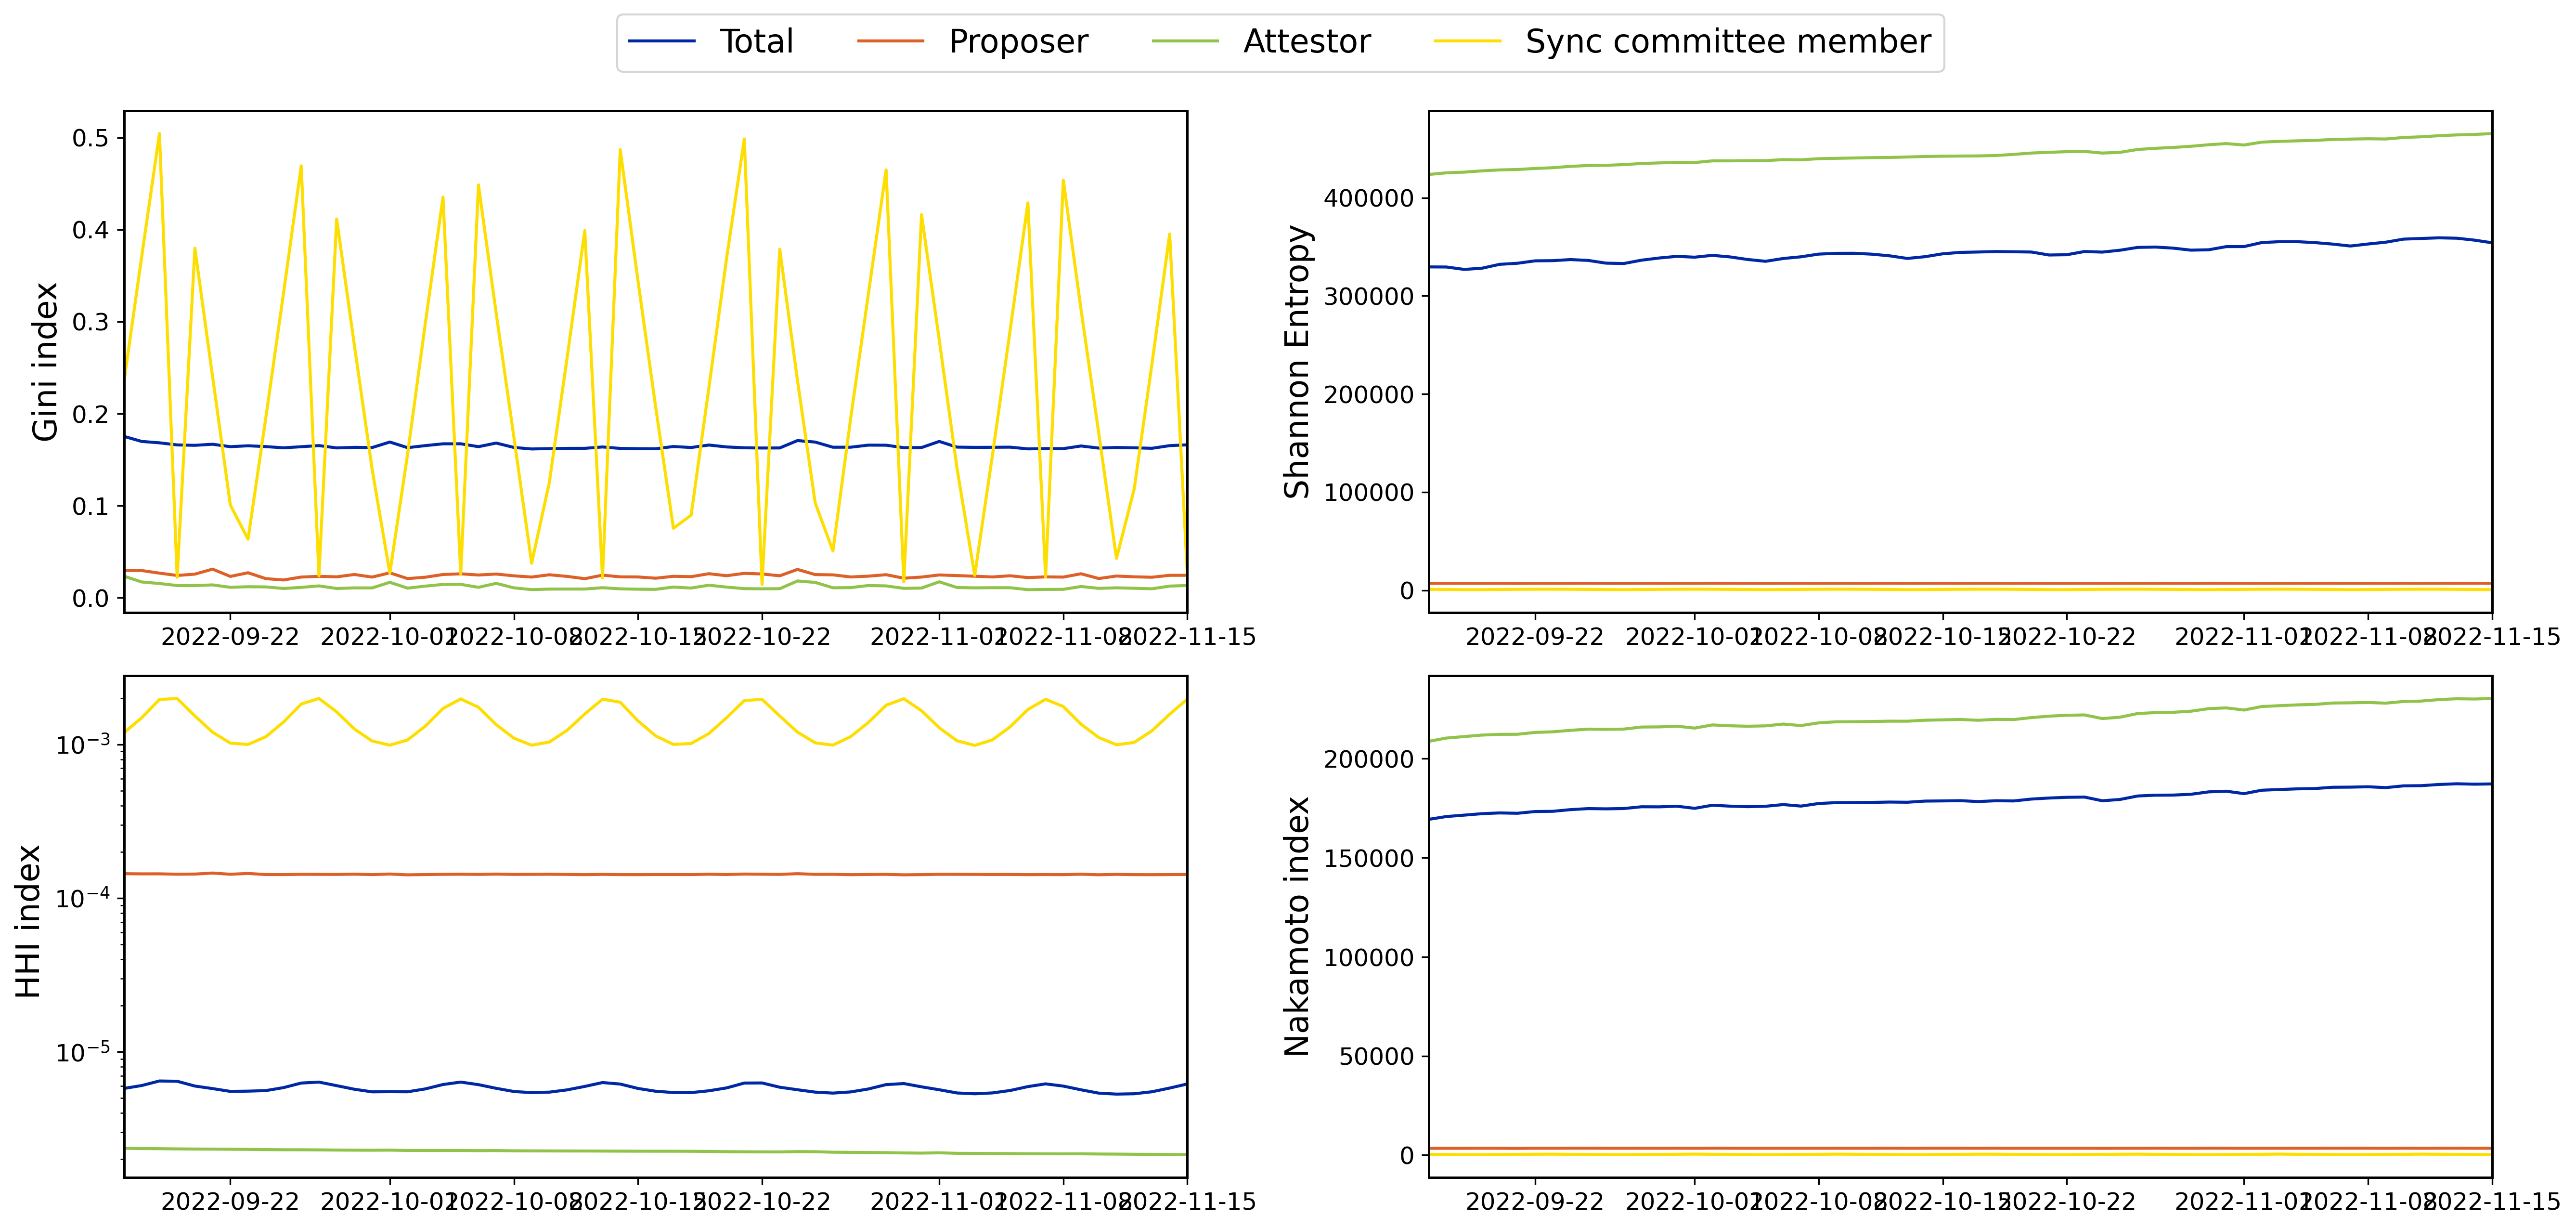

In [31]:
from glob import glob
files=glob('../data/index_data_3/*.csv')
validator_counts =pd.read_csv('../data/daily_validator_number_new.csv')
fig,axes=plt.subplots(2,2,figsize=(18,8),dpi=300)
for file in files:
    index=pd.read_csv(file)
    index['date']=pd.to_datetime(index['date'])
    index_name=file.split('/')[-1].split('.')[0].split('_')[0]
    index_name=index_name[0].upper()+index_name[1:]
    reward_type=file.split('/')[-1].split('.')[0].split('_')[1]
    # reward_type=['Total','Proposer','Attestor','Sync committee member']
    if index_name=='Gini':
        axes[0,0].plot(index['date'],index[reward_type],label=reward_type)
        
        axes[0,0].set_ylabel(f'{index_name} index',fontsize=16)
        
        # axes[0,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        # axes[0,0].legend(fontsize=16,ncol=2)
        
        axes[0,0].autoscale(enable=True, axis='x', tight=True)
        axes[0,0].set_xlim(left=pd.to_datetime('2022-09-16'))
        # axes[0,0].set_yscale('log') 
    if index_name=='Index':
        axes[0,1].plot(index['date'],index[reward_type],label=reward_type)
        axes[0,1].set_ylabel(f'Shannon Entropy',fontsize=16)
        #
        # axes[0,1].legend(fontsize=16,ncol=2)
        axes[0,1].autoscale(enable=True, axis='x', tight=True)
        axes[0,1].set_xlim(left=pd.to_datetime('2022-09-16'))
    
    if index_name=='HHI':
        # reviese_HHI=index[reward_type]* validator_counts['validator_index'][1:].values
        axes[1,0].plot(index['date'],index[reward_type],label=reward_type)
        # axes[1,0].plot(index['date'],reviese_HHI,label=reward_type)
        axes[1,0].set_ylabel(f' HHI index',fontsize=16)
        # use percentage to show y axis
        axes[1,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
        # axes[1,0].legend(fontsize=16,ncol=2)
        axes[1,0].autoscale(enable=True, axis='x', tight=True)
        axes[1,0].set_xlim(left=pd.to_datetime('2022-09-16'))
        axes[1,0].set_yscale('log')
        
    if index_name=='Nakamoto':
        axes[1,1].plot(index['date'],index[reward_type],label=reward_type)
        axes[1,1].set_ylabel(f'{index_name} index',fontsize=16)
        
        # axes[1,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        # axes[1,1].legend(fontsize=16,ncol=2)
        axes[1,1].autoscale(enable=True, axis='x', tight=True)
        axes[1,1].set_xlim(left=pd.to_datetime('2022-09-16'))
plt.tight_layout()

handles, labels = axes[0,0].get_legend_handles_labels()
labels[0]='Total'
labels[1]='Proposer'
labels[2]='Attestor'
labels[3]='Sync committee member'
plt.legend(handles,labels,fontsize=16,ncol=4,bbox_to_anchor=(0.5,2.35),frameon=True)
# plt.legend(fontsize=16,ncol=4,bbox_to_anchor=(0.5,2.35),frameon=True)

# plt.savefig('../figure/4_index_timeseries.pdf',bbox_inches='tight',dpi=300,facecolor='white')



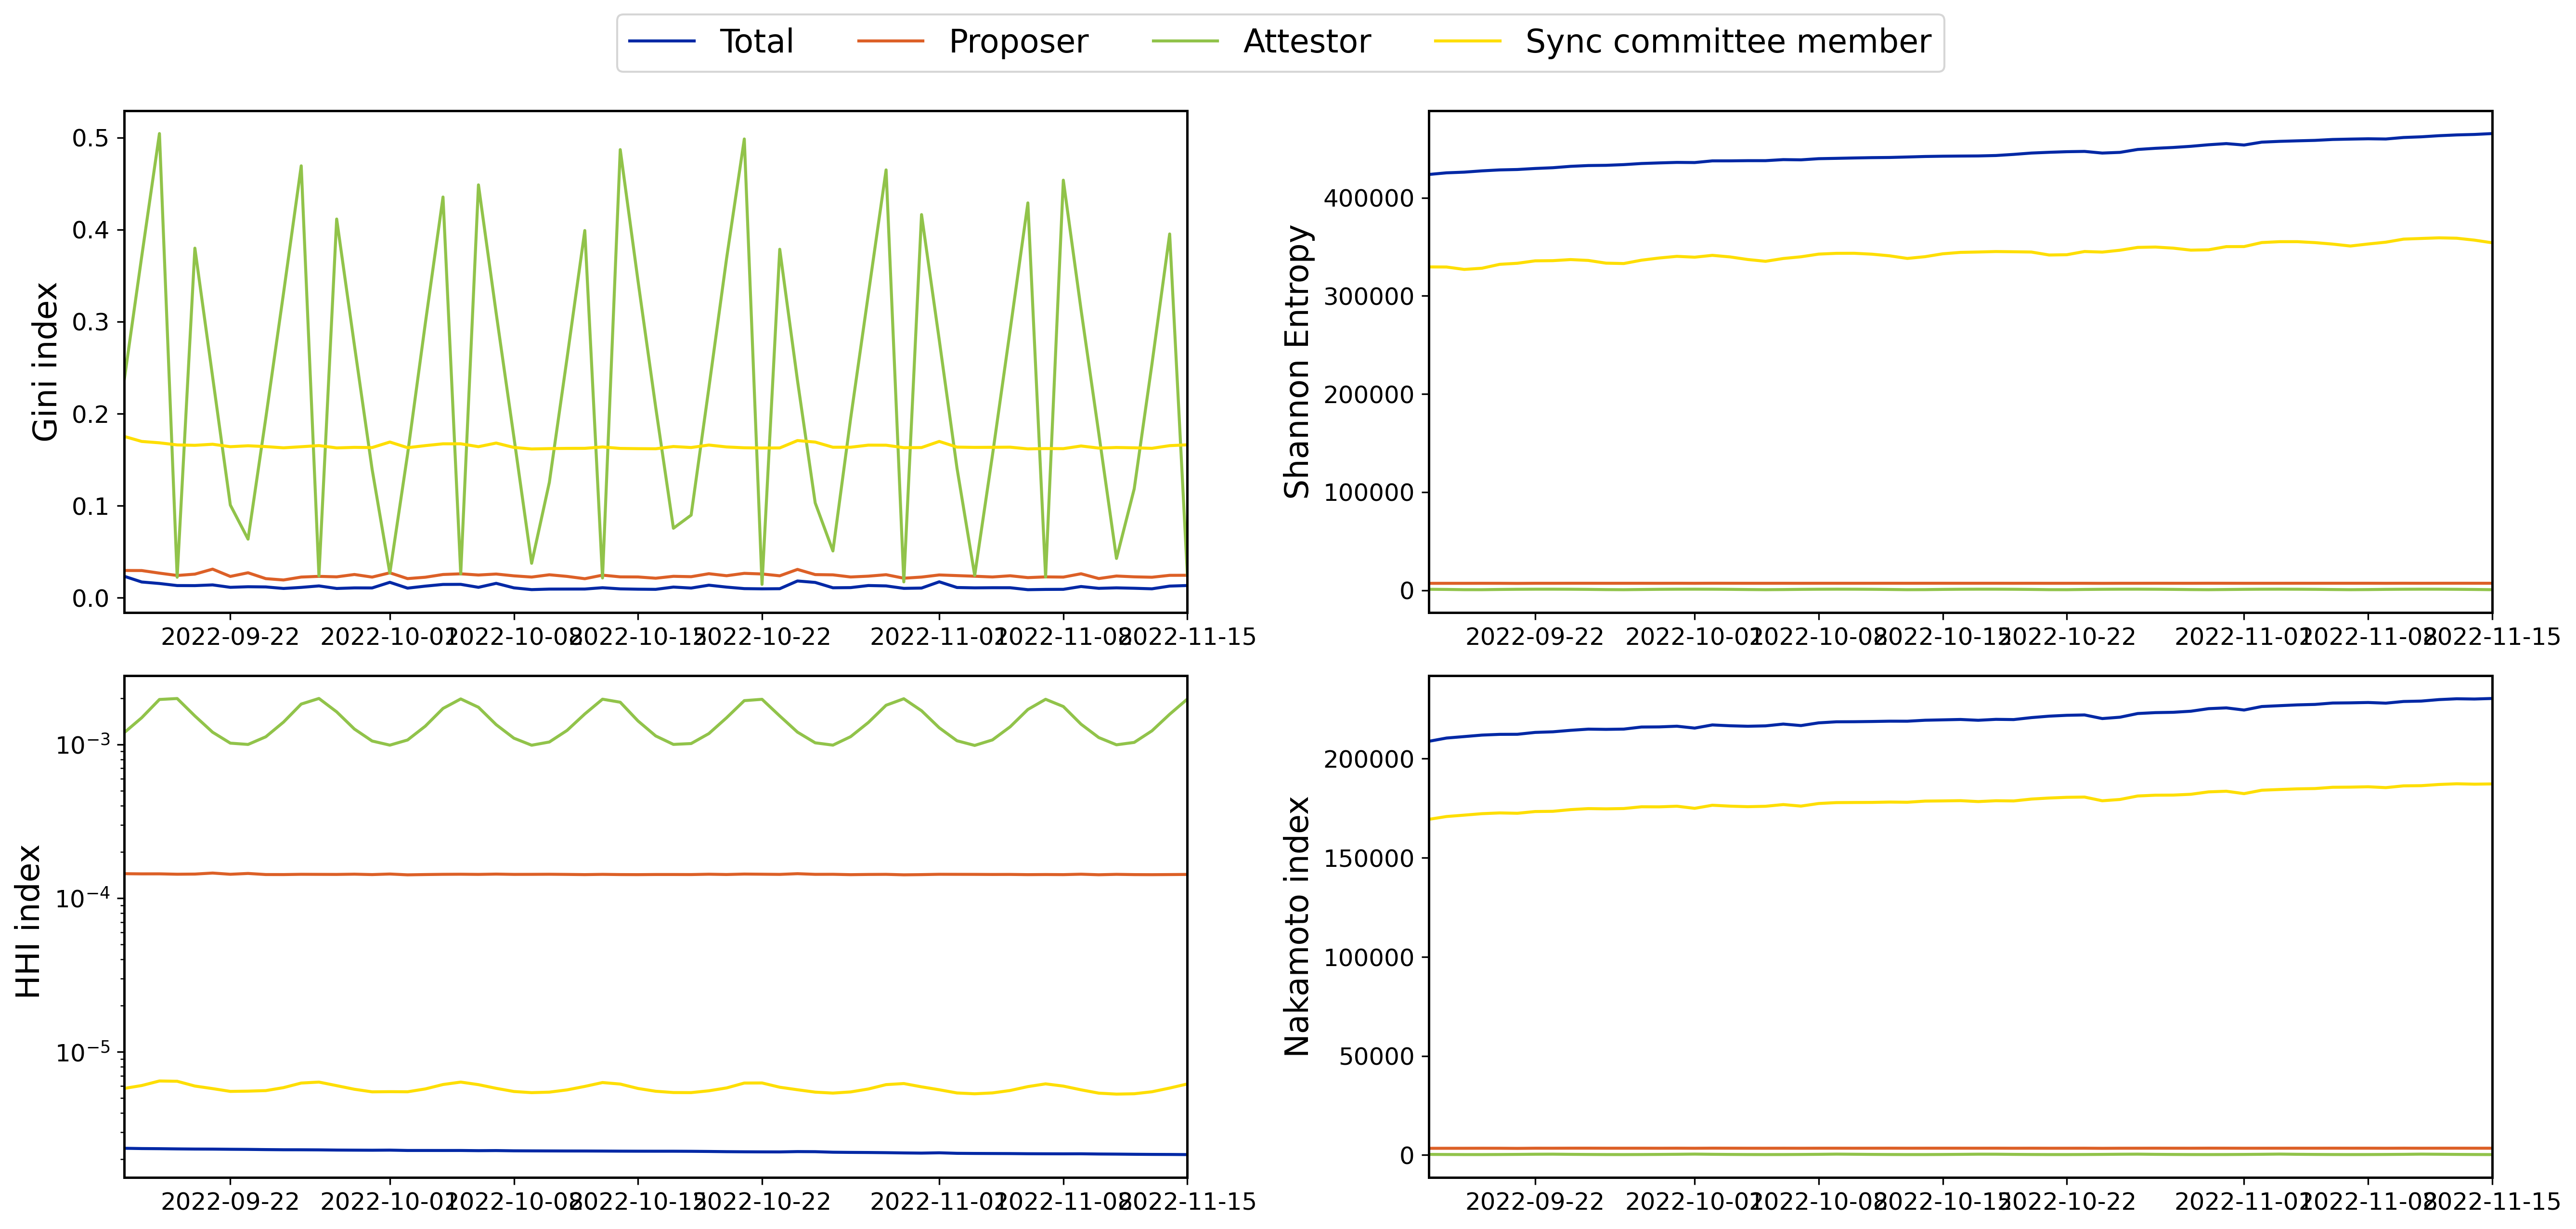

In [10]:
from glob import glob
files=glob('../data/index_data_3/*.csv')
validator_counts =pd.read_csv('../data/daily_validator_number_new.csv')
# 2*2 subplots
fig,axes=plt.subplots(2,2,figsize=(18,8),dpi=300)
for file in files:
    index=pd.read_csv(file)
    index['date']=pd.to_datetime(index['date'])
    index_name=file.split('/')[-1].split('.')[0].split('_')[0]
    index_name=index_name[0].upper()+index_name[1:]
    reward_type=file.split('/')[-1].split('.')[0].split('_')[1]
    # reward_type=['Total','Proposer','Attestor','Sync committee member']
    if index_name=='Gini':
        axes[0,0].plot(index['date'],index[reward_type],label=reward_type)
        #set the y-axis label
        axes[0,0].set_ylabel(f'{index_name} index',fontsize=16)
        #use percentage for y-axis
        # axes[0,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        # axes[0,0].legend(fontsize=16,ncol=2)
        axes[0,0].autoscale(enable=True, axis='x', tight=True)
        axes[0,0].set_xlim(left=pd.to_datetime('2022-09-16'))
        # axes[0,0].set_yscale('log') 
    if index_name=='Index':
        axes[0,1].plot(index['date'],index[reward_type],label=reward_type)
        axes[0,1].set_ylabel(f'Shannon Entropy',fontsize=16)
        #use percentage for y-axis
        # axes[0,1].legend(fontsize=16,ncol=2)
        axes[0,1].autoscale(enable=True, axis='x', tight=True)
        axes[0,1].set_xlim(left=pd.to_datetime('2022-09-16'))
    
    if index_name=='HHI':
        # reviese_HHI=index[reward_type]* validator_counts['validator_index'][1:].values
        axes[1,0].plot(index['date'],index[reward_type],label=reward_type)
        # axes[1,0].plot(index['date'],reviese_HHI,label=reward_type)
        axes[1,0].set_ylabel(f' HHI index',fontsize=16)
        #use percentage for y-axis
        axes[1,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
        # axes[1,0].legend(fontsize=16,ncol=2)
        axes[1,0].autoscale(enable=True, axis='x', tight=True)
        axes[1,0].set_xlim(left=pd.to_datetime('2022-09-16'))
        axes[1,0].set_yscale('log')
        
    if index_name=='Nakamoto':
        axes[1,1].plot(index['date'],index[reward_type],label=reward_type)
        axes[1,1].set_ylabel(f'{index_name} index',fontsize=16)
        #use percentage for y-axis
        # axes[1,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        # axes[1,1].legend(fontsize=16,ncol=2)
        axes[1,1].autoscale(enable=True, axis='x', tight=True)
        axes[1,1].set_xlim(left=pd.to_datetime('2022-09-16'))
plt.tight_layout()
#rename the legend
handles, labels = axes[0,0].get_legend_handles_labels()
labels[0]='Total'
labels[1]='Proposer'
labels[2]='Attestor'
labels[3]='Sync committee member'
#set the legend location
plt.legend(handles,labels,fontsize=16,ncol=4,bbox_to_anchor=(0.5,2.35),frameon=True)
# plt.savefig('../figure/4_index_timeseries.pdf',bbox_inches='tight',dpi=300,facecolor='white')



# References:
Code adapted from SoK: Blockchain Decentralization: https://arxiv.org/abs/2205.04256